# Titanic - Machine Learning from Disaster

This is my first attempt at a Kaggle competition. Let us start by importing the necessary libraries: 


In [1]:
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## I - Loading and exploring data

### a) Loading data

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_all = pd.concat([df_train, df_test], sort=False)
display(df_all.head())
print(df_all.dtypes)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


Convert some columns to numeric, extract titles from names, add family size, add family survival features and regroup some features.

In [3]:
df_all["Sex"] = df_all["Sex"].map({"male": 0, "female": 1})
df_all["Embarked"] = df_all["Embarked"].map({"S": 0, "C": 1, "Q": 2})
df_all['Title'] = df_all['Name'].str.split(',').str[1].str.split('.').str[0]
df_all['Title'] = df_all['Title'].map({
    " Mr": 0, " Mrs": 0, " Miss": 0, " Ms": 0,    
    " Master": 1, " Mlle": 1,                   
    " Don": 2, " Lady": 2, " Sir": 2, " the Countess": 2, " Jonkheer": 2, 
    " Rev": 3, " Dr": 3, " Major": 3, " Col": 3, " Capt": 3 
})
df_all['FamilySize'] = df_all['SibSp'] + df_all['Parch'] + 1
df_all['SmallFamily'] = 0
df_all.loc[df_all['FamilySize'] <= 2, 'SmallFamily'] = 1
df_all['LargeFamily'] = 0
df_all.loc[df_all['FamilySize'] >= 5, 'LargeFamily'] = 1
df_all["IsAlone"] = 0
df_all.loc[df_all["FamilySize"] == 1, "IsAlone"] = 1

df_all.drop(['Cabin','Name','SibSp','Parch','Ticket'], axis=1, inplace=True)

display(df_all.head())


,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,SmallFamily,LargeFamily,IsAlone
0,1,0.0,3,0,22.0,7.2500,0.0,0.0,2,1,0,0
1,2,1.0,1,1,38.0,71.2833,1.0,0.0,2,1,0,0
2,3,1.0,3,1,26.0,7.9250,0.0,0.0,1,1,0,1
3,4,1.0,1,1,35.0,53.1000,0.0,0.0,2,1,0,0
4,5,0.0,3,0,35.0,8.0500,0.0,0.0,1,1,0,1


Let's extract and separate the first letters and numbers of the Cabine column into two new columns:

### b) Visualizing  data

After loading the data, we will visualize the data to get a better understanding.

In [4]:
print(f"The DataFrame df_train has {df_all.shape[0]} rows and {df_all.shape[1]} columns.\n")

print("Descriptive statistics for the df_train DataFrame, rounded to two decimal places:") 
display(df_all.describe().round(1))

print("\nPercentage of missing values in each column of the df_train DataFrame:")
display(df_all.isnull().mean().mul(100).round(1).reset_index().rename(columns={0: 'Percentage', 'index': 'Column'}))

The DataFrame df_train has 1309 rows and 12 columns.

Descriptive statistics for the df_train DataFrame, rounded to two decimal places:


,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,SmallFamily,LargeFamily,IsAlone
count,1309.0,891.0,1309.0,1309.0,1046.0,1308.0,1307.0,1307.0,1309.0,1309.0,1309.0,1309.0
mean,655.0,0.4,2.3,0.4,29.9,33.3,0.4,0.1,1.9,0.8,0.1,0.6
std,378.0,0.5,0.8,0.5,14.4,51.8,0.7,0.5,1.6,0.4,0.2,0.5
min,1.0,0.0,1.0,0.0,0.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0
25%,328.0,0.0,2.0,0.0,21.0,7.9,0.0,0.0,1.0,1.0,0.0,0.0
50%,655.0,0.0,3.0,0.0,28.0,14.5,0.0,0.0,1.0,1.0,0.0,1.0
75%,982.0,1.0,3.0,1.0,39.0,31.3,1.0,0.0,2.0,1.0,0.0,1.0
max,1309.0,1.0,3.0,1.0,80.0,512.3,2.0,3.0,11.0,1.0,1.0,1.0



Percentage of missing values in each column of the df_train DataFrame:


,Column,Percentage
0,PassengerId,0.0
1,Survived,31.9
2,Pclass,0.0
3,Sex,0.0
4,Age,20.1
5,Fare,0.1
6,Embarked,0.2
7,Title,0.2
8,FamilySize,0.0
9,SmallFamily,0.0


Repartition of some features:

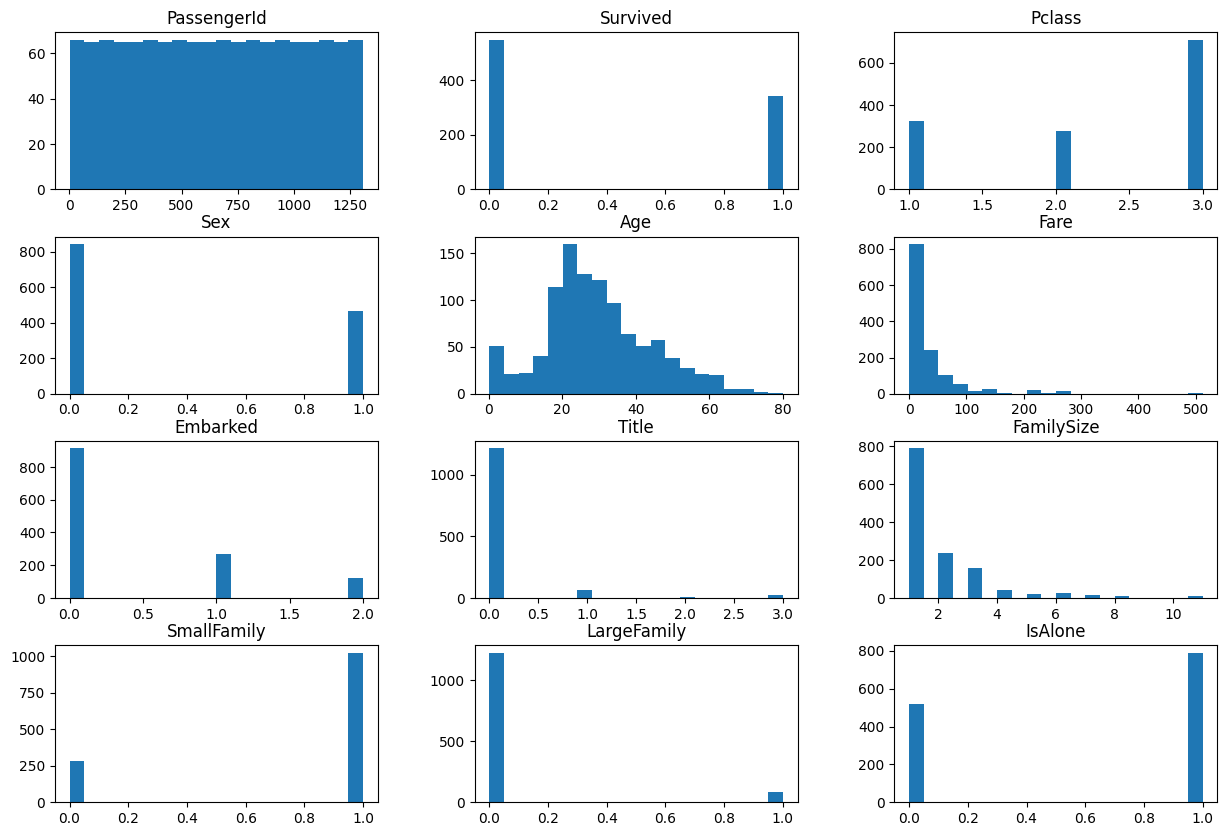

In [5]:
df_all.hist(figsize=(15, 10), bins=20, grid=False);

It interesting to visualize age distribution by survival.

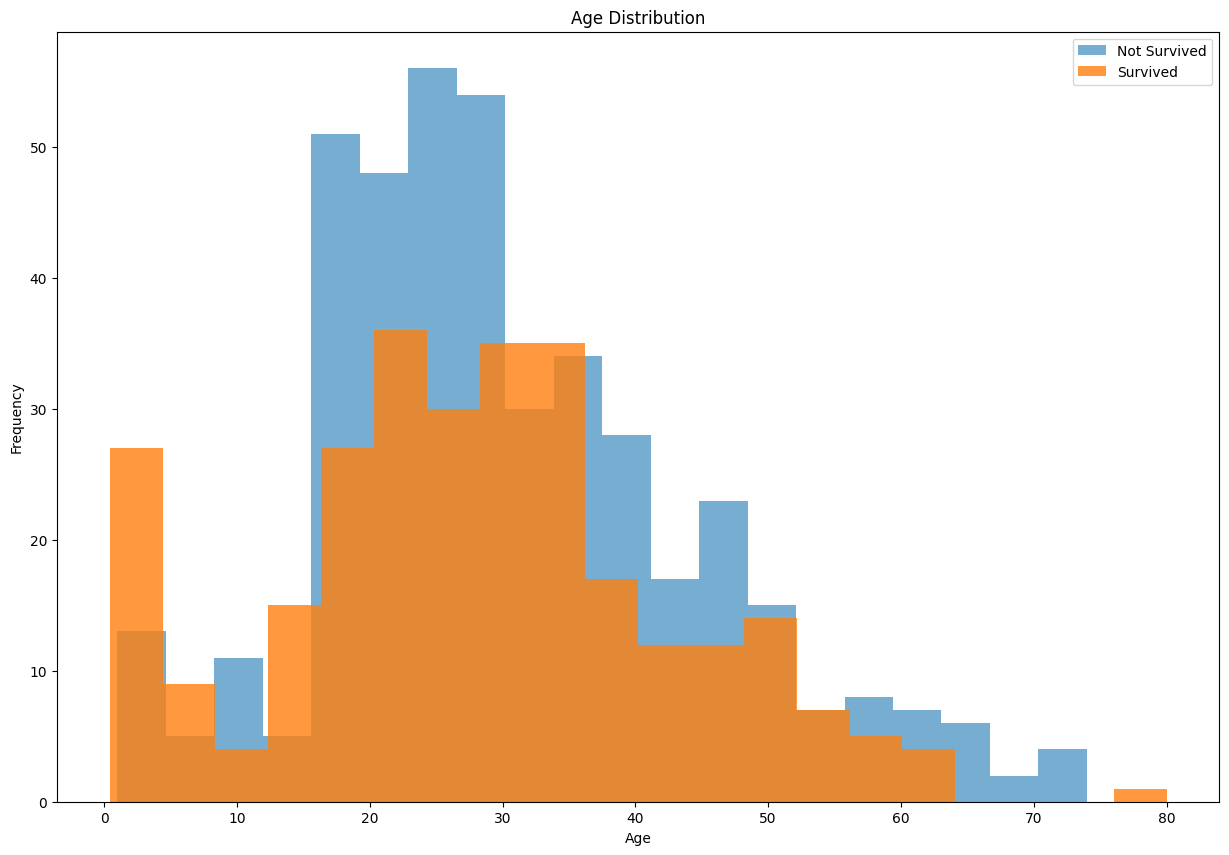

In [6]:
plt.figure(figsize=(15, 10))
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.hist(df_all[df_all['Survived'] == 0]['Age'].dropna(), bins=20, label='Not Survived', alpha=0.6)
plt.hist(df_all[df_all['Survived'] == 1]['Age'].dropna(), bins=20, label='Survived', alpha=0.8)
plt.legend()
plt.show()

It also interesting to visualize some other features by survival.

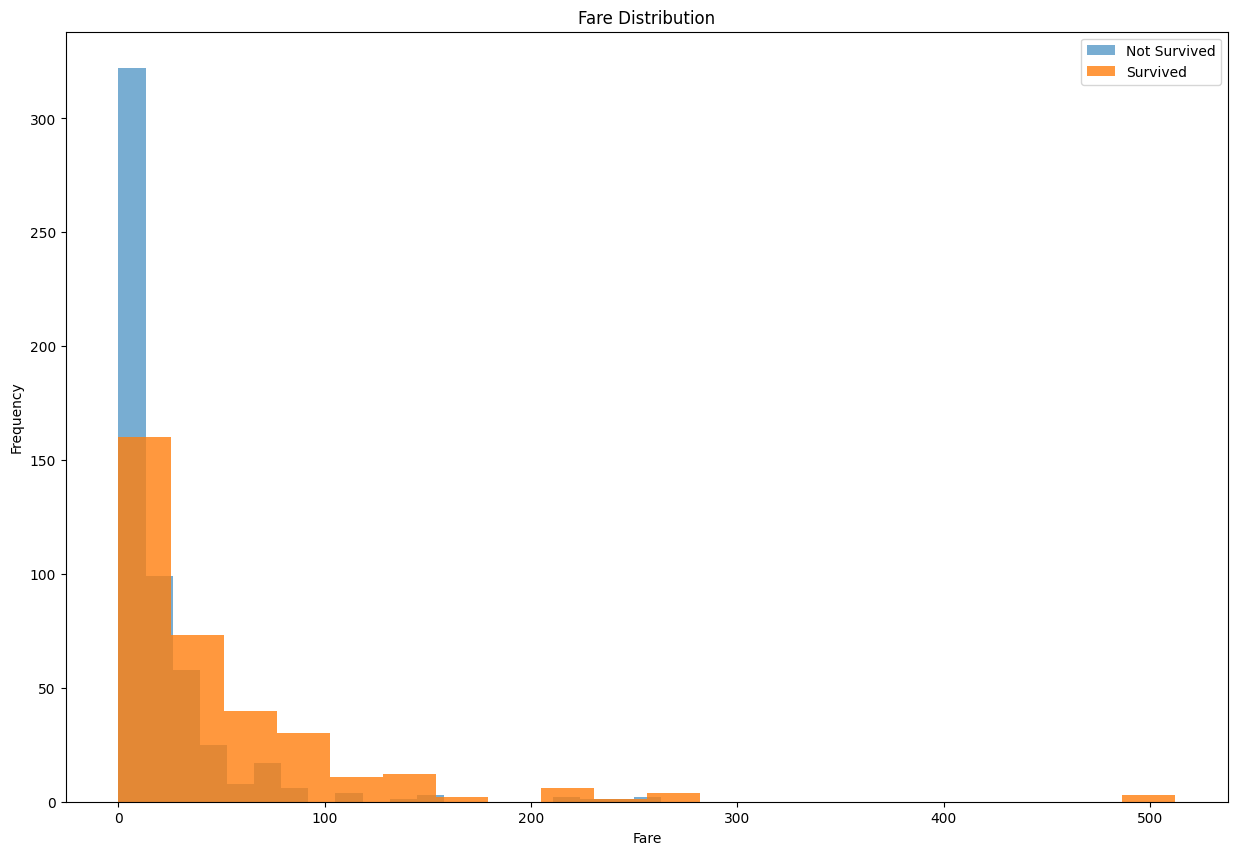

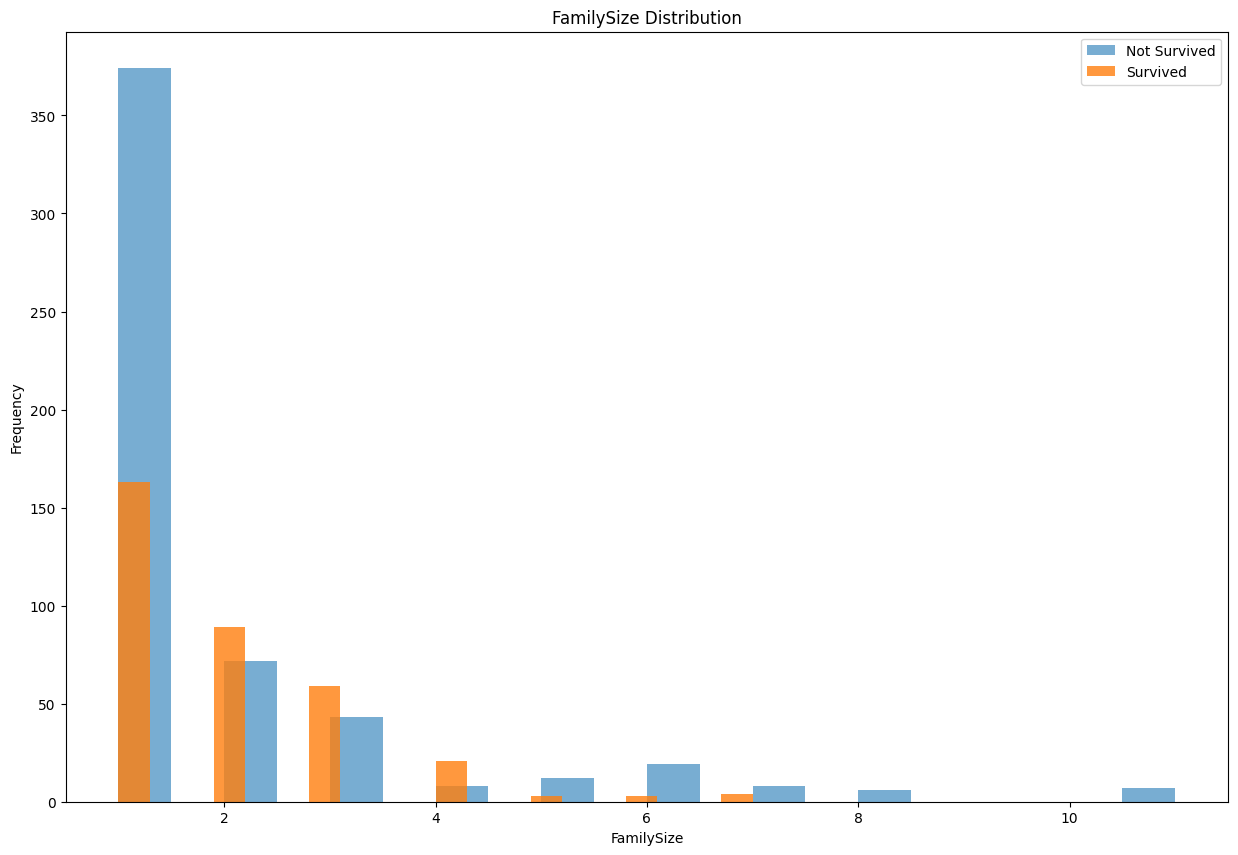

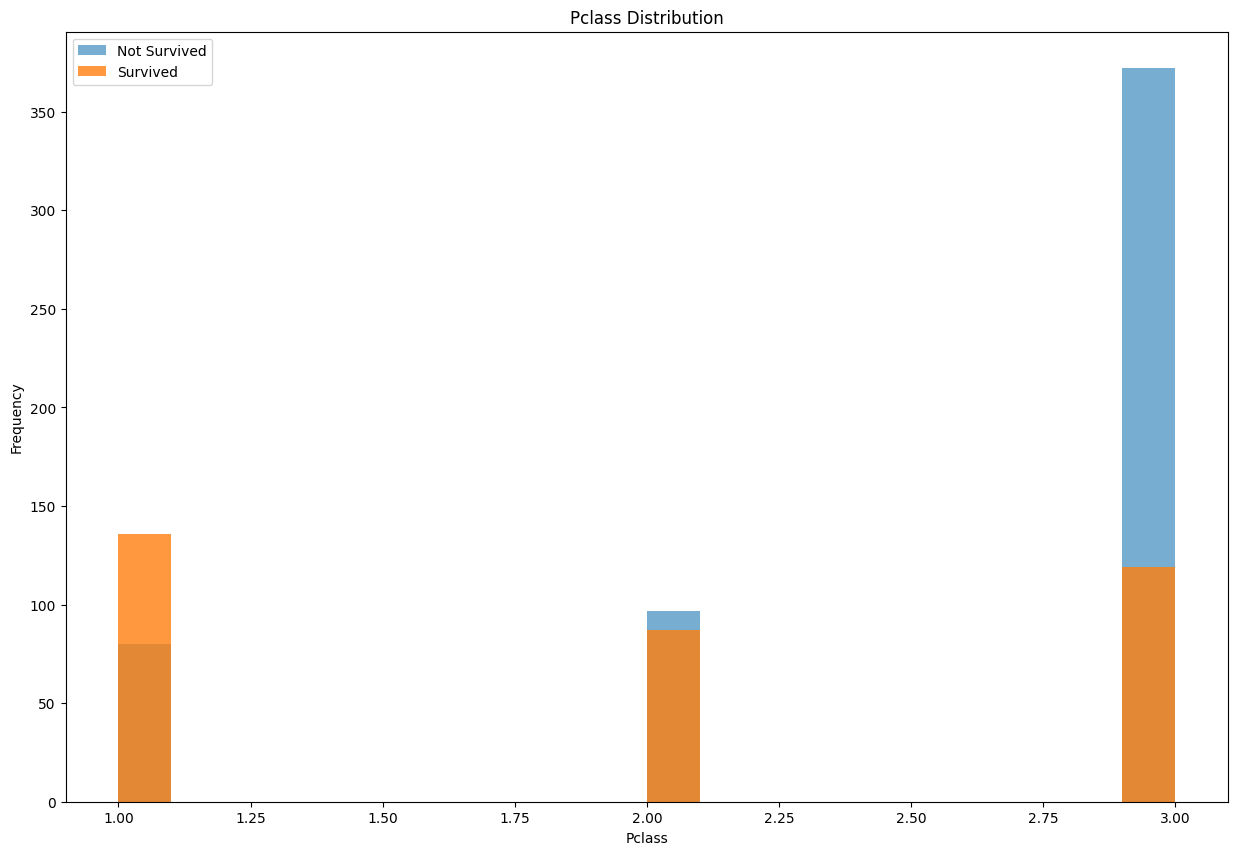

In [7]:
plt.figure(figsize=(15, 10))
plt.title('Fare Distribution')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.hist(df_all[df_all['Survived'] == 0]['Fare'].dropna(), bins=20, label='Not Survived', alpha=0.6)
plt.hist(df_all[df_all['Survived'] == 1]['Fare'].dropna(), bins=20, label='Survived', alpha=0.8)
plt.legend()
plt.show()

plt.figure(figsize=(15, 10))
plt.title('FamilySize Distribution')
plt.xlabel('FamilySize')
plt.ylabel('Frequency')
plt.hist(df_all[df_all['Survived'] == 0]['FamilySize'].dropna(), bins=20, label='Not Survived', alpha=0.6)
plt.hist(df_all[df_all['Survived'] == 1]['FamilySize'].dropna(), bins=20, label='Survived', alpha=0.8)
plt.legend()
plt.show()

plt.figure(figsize=(15, 10))
plt.title('Pclass Distribution')
plt.xlabel('Pclass')
plt.ylabel('Frequency')
plt.hist(df_all[df_all['Survived'] == 0]['Pclass'].dropna(), bins=20, label='Not Survived', alpha=0.6)
plt.hist(df_all[df_all['Survived'] == 1]['Pclass'].dropna(), bins=20, label='Survived', alpha=0.8)
plt.legend()
plt.show()



### c) Replacing missing values

We will replace missing values with two different methods:
- Replace missing values with predicted values
- Replace missing values with mean values

But first , we replace missing values in the Title column and in Fare colimn with the most common value.

In [8]:
df_all['Fare'].fillna(df_all['Fare'].mode()[0], inplace=True)
df_all['Title'].fillna(df_all['Title'].mode()[0], inplace=True)
df_all['Embarked'].fillna(df_all['Embarked'].mode()[0], inplace=True)


#### `Predicting missing values`



##### Age column

Let us replace the missing values of the Age column by a prediction of the age based on the other columns with a RandomForestRegressor.

In [9]:
df_all_pred = df_all.copy()

known_age = df_all_pred[df_all_pred['Age'].notnull()]
unknown_age = df_all_pred[df_all_pred['Age'].isnull()]

features = ['Pclass', 'Title', 'Sex', 'Fare','FamilySize', 
            'SmallFamily', 'LargeFamily','Embarked']
target = 'Age'

X = known_age[features]
y = known_age[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Mean squarred error: {mse:.2f}")

predicted_ages = best_model.predict(unknown_age[features])
df_all_pred.loc[df_all_pred['Age'].isnull(), 'Age'] = predicted_ages

Mean squarred error: 10.75


Plot repartition before and after prediction:

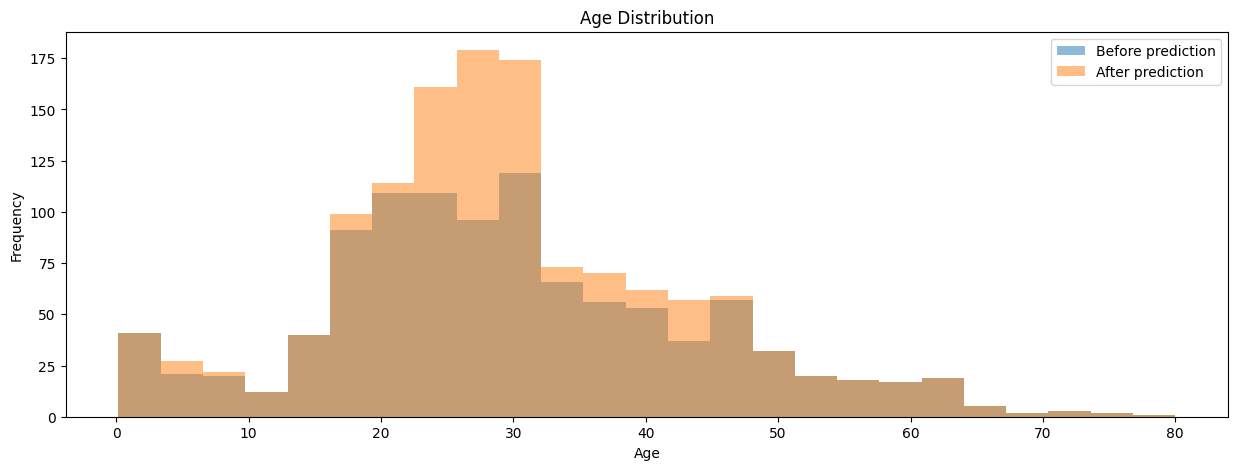

In [10]:
plt.figure(figsize=(15, 5))
plt.hist(df_all['Age'], bins=25, alpha=0.5, label='Before prediction')
plt.hist(df_all_pred['Age'], bins=25, alpha=0.5, label='After prediction')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

In [11]:
print("\nPercentage of missing values in each column of df_all_pred:")
print(df_all_pred.isnull().mean().mul(100).round(1).reset_index().rename(columns={0: 'Percentage', 'index': 'Column'}))


Percentage of missing values in each column of df_all_pred:
         Column  Percentage
0   PassengerId         0.0
1      Survived        31.9
2        Pclass         0.0
3           Sex         0.0
4           Age         0.0
5          Fare         0.0
6      Embarked         0.0
7         Title         0.0
8    FamilySize         0.0
9   SmallFamily         0.0
10  LargeFamily         0.0
11      IsAlone         0.0


Transform to dummy values:

#### `Mean values`

We will fix the missing values in Age, Cabin and Embarked with mean value from the same column.

In [12]:
df_all_mean = df_all.copy()
df_all_mean['Age'].fillna(df_all_mean['Age'].mean(), inplace=True)
df_all_mean['Embarked'].fillna(df_all_mean['Embarked'].mean(), inplace=True)

Plot repartition before and after prediction for Age, Numbers_Cabine and Letter_Cabine columns:

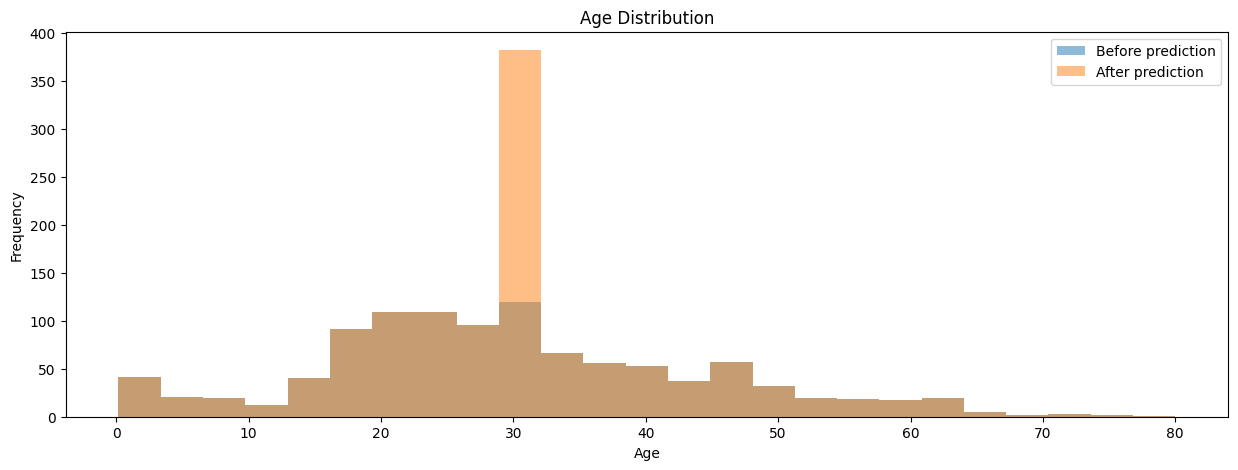

In [13]:
plt.figure(figsize=(15, 5))
plt.hist(df_all['Age'], bins=25, alpha=0.5, label='Before prediction')
plt.hist(df_all_mean['Age'], bins=25, alpha=0.5, label='After prediction')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

### d) Spliting data into train and test sets

In [14]:
df_train = df_all_pred[df_all_mean['Survived'].notnull()]
X = df_train.drop(['Survived', 'PassengerId'], axis=1)
y = df_train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

df_train_mean = df_all_mean[df_all_mean['Survived'].notnull()]
X_mean = df_train_mean.drop(['Survived', 'PassengerId'] , axis=1)
y_mean = df_train_mean['Survived']
X_train_mean, X_test_mean, y_train_mean, y_test_mean = train_test_split(X_mean, y_mean, test_size=0.2, random_state=2)

## II - First model - Logistic Regression

In [15]:
model_lg = LogisticRegression(max_iter=10000)
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}


- Prediction_model 

In [16]:
grid_search = GridSearchCV(estimator=model_lg, param_grid=parameters, cv=10)
grid_search.fit(X_train, y_train)
lg_pred = grid_search.best_estimator_

print("Best score: ", grid_search.best_score_)

Best score:  0.8243740219092333


- Mean_model

In [17]:
grid_search = GridSearchCV(estimator=model_lg, param_grid=parameters, cv=10)
grid_search.fit(X_train_mean, y_train_mean)
lg_mean = grid_search.best_estimator_

print("Best score: ", grid_search.best_score_)

Best score:  0.8229851330203444


## Second model - Random Forest

In [18]:
model_random_forest = RandomForestClassifier(random_state=2)

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500,750, 1000, 1500],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}


- Prediction_model

In [19]:
grid_search = GridSearchCV(estimator=model_random_forest, param_grid=param_grid, cv=5, verbose=1)
grid_search.fit(X, y)
model_random_forest_pred = grid_search.best_estimator_

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 1000}
Best cross-validation score: 0.83


- Mean_model

In [20]:
grid_search = GridSearchCV(estimator=model_random_forest, param_grid=param_grid, cv=5, verbose=1)
grid_search.fit(X_mean, y_mean)
model_random_forest_mean = grid_search.best_estimator_

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Best parameters: {'max_depth': 9, 'min_samples_leaf': 3, 'n_estimators': 500}
Best cross-validation score: 0.83


## Third model - LightGBM

In [21]:
gbm = lgb.LGBMClassifier(verbose=-1)

param_grid = {
    'learning_rate': [0.01, 0.1, 0.15, 0.25, 0.5],
    'num_leaves': [31, 50, 100],
    'max_bin': [255, 500, 1000, 1500]
}

- Prediction_model

In [22]:
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, scoring='accuracy', verbose=0)
grid_search.fit(X, y)
gbm_pred = grid_search.best_estimator_

print("Best parameters", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters {'learning_rate': 0.1, 'max_bin': 255, 'num_leaves': 50}
Best cross-validation score: 0.8282907538760906


- Mean_model

In [23]:
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, scoring='accuracy', verbose=0)
grid_search.fit(X_mean, y_mean)
gbm_mean = grid_search.best_estimator_

print("Best parameters", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters {'learning_rate': 0.1, 'max_bin': 255, 'num_leaves': 50}
Best cross-validation score: 0.8238340342728014


## Fourth model - XGBoost

In [24]:
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [100, 200, 300, 400],
    'subsample': [0.8, 0.9, 1.0]
}

- Prediction_model

In [25]:
xgb_model = xgb.XGBClassifier()

grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X, y)
xgb_best_pred = grid_search.best_estimator_

print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Best parameters:  {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation score:  0.8462557278262507


- Mean_model

In [26]:
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_mean, y_mean)
xgb_best_mean= grid_search.best_estimator_

print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Best parameters:  {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.9}
Best cross-validation score:  0.8451321323206328


# II - Resume of the results

Synthesis of the results of the different models:

| Modèle            | Prediction_model | Mean_model |
|-------------------|------------------|------------|
| Logistic Regression | 82.43            | 82.29      |
| Random Forest       | 83               | 83         |
| LightGBM            | 82.82            | 82.38      |
| XGBoost             | 84.62            | 84.51      |

Now, draw features importance for each model:

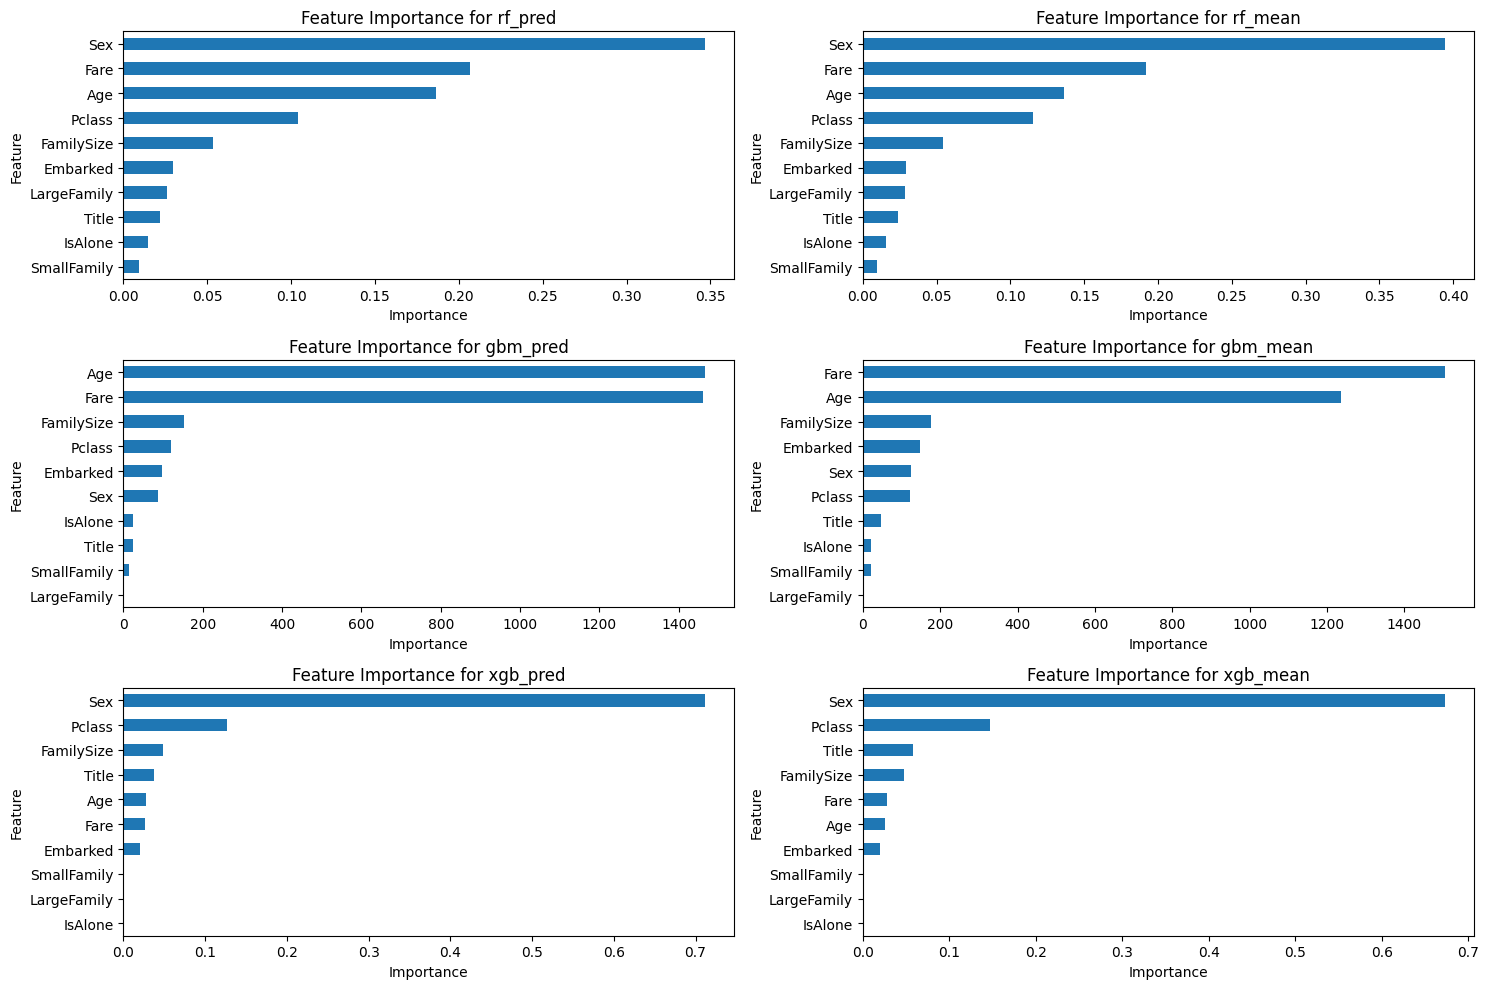

In [27]:
models = [
    {"name": "rf_pred", "model": model_random_forest_pred, "features": X.columns},
    {"name": "rf_mean", "model": model_random_forest_mean, "features": X_mean.columns},
    {"name": "gbm_pred", "model": gbm_pred, "features": X.columns},
    {"name": "gbm_mean", "model": gbm_mean, "features": X_mean.columns},
    {"name": "xgb_pred", "model": xgb_best_pred, "features": X.columns},
    {"name": "xgb_mean", "model": xgb_best_mean, "features": X_mean.columns}
]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))

for i, mod in enumerate(models):
    feature_importance = pd.DataFrame({
        'feature': mod["features"],
        'importance': mod["model"].feature_importances_
    })

    feature_importance.sort_values(by='importance', ascending=False, inplace=True)
    feature_importance.reset_index(drop=True, inplace=True)

    ax = axs[i//2, i%2]
    feature_importance.head(10).plot(kind='barh', x='feature', y='importance', legend=False, ax=ax)
    ax.set_title(f'Feature Importance for {mod["name"]}')
    ax.set_xlabel('Importance')
    ax.set_ylabel('Feature')
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

# III - Evaluate on the test set

In [28]:
df_test = df_all_pred[df_all_pred['Survived'].isnull()].copy()
df_id = df_test['PassengerId']
df_test.drop(['Survived', 'PassengerId'], axis=1, inplace=True)

df_test0 = df_all_mean[df_all_mean['Survived'].isnull()].copy()
df_id1 = df_test0['PassengerId']
df_test0.drop(['Survived', 'PassengerId'], axis=1, inplace=True)

display(df_test.head())

,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,SmallFamily,LargeFamily,IsAlone
0,3,0,34.5,7.8292,2.0,0.0,1,1,0,1
1,3,1,47.0,7.0000,0.0,0.0,2,1,0,0
2,2,0,62.0,9.6875,2.0,0.0,1,1,0,1
3,3,0,27.0,8.6625,0.0,0.0,1,1,0,1
4,3,1,22.0,12.2875,0.0,0.0,3,0,0,0


In [29]:
y_pred_lg = lg_pred.predict(df_test).round().astype(int)
y_mean_lg = lg_mean.predict(df_test0).round().astype(int)

y_pred_rf = model_random_forest_pred.predict(df_test).astype(int)
y_mean_rf = model_random_forest_mean.predict(df_test0).astype(int)

y_pred_gbm = gbm_pred.predict(df_test).astype(int)
y_mean_gbm = gbm_mean.predict(df_test0).astype(int)

y_pred_xgb = xgb_best_pred.predict(df_test)
y_mean_xgb = xgb_best_mean.predict(df_test0)

In [32]:
predictions = [
    {"name": "lg_pred", "pred": y_pred_lg},
    {"name": "lg_mean", "pred": y_mean_lg},
    {"name": "rf_pred", "pred": y_pred_rf},
    {"name": "rf_mean", "pred": y_mean_rf},
    {"name": "gbm_pred", "pred": y_pred_gbm},
    {"name": "gbm_mean", "pred": y_mean_gbm},
    {"name": "xgb_pred", "pred": y_pred_xgb},
    {"name": "xgb_mean", "pred": y_mean_xgb}
]

for pred in predictions:
    submission = pd.DataFrame({
        'PassengerId': df_id, 
        'Survived': pred["pred"]
    })

    submission.to_csv(f'gender_submission_{pred["name"]}.csv', index=False)

# IV - Results

Best model is XGBoost with 78.947% of accuracy.